<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap11_2_cnn_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capítulo 11 - Redes Neurais Convolucionais

## 11.2 - Implementando uma AlexNet para Classificação de Imagens de Documentos

A AlexNet é uma arquitetura rede neural convolucional profunda desenvolvida em 2012 para a tradicional competição de classificação e reconhecimento de imagens ImageNet.

Você pode consultar o artigo da AlexNet [aqui](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

A arquitetura da AlexNet é representada graficamente pela seguinte figura:

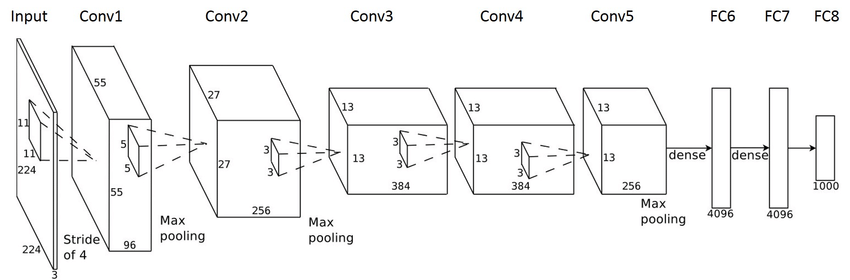

Informações sobre a coleção de imagens utilizada. É uma amostragem aleatória do conjunto

In [1]:
!pip install -U keras
!pip install tensorflow

### Leitura das imagens

Fazer o carregamento de coleções de imagens que estão já carregadas dentro do Keras-tensorflow é tranquilo, vide o [Cifar-10 (recomendo ver este link)](https://keras.io/api/datasets/cifar10/). E quando temos e queremos processar nossas próprias imagens? Aí é um pouco mais difícil, mas não impossível!

Para viabilizar o carregamento das imagens em uma estrutura que permita ler as imagens do disco e processá-las pelos objetos do Keras-tensorflow, vamos utilizar a classe [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Os principais motivos dessa escolha são:

*   Facilidade de se carregar imagens diretamente do disco ou por DataFrames;
*   Facilidade de utilizar operações de pré-processamento (normalização, reescalonamento etc) e que podem ser úteis em uma etapa conhecida como DataAugmentation (veremos adiante)!

### Organizando os arquivos das imagens

A pasta principal da coleção de imagens possui nome "documents". Dentro dessa pasta existem três subpastas, cada uma associada com uma label:

*   documents
    + advertisement
    + email
    + scientific paper

Nesse notebook, teremos que dividir a coleção de imagens em sub-partes (treinamento, validação e testes) utilizando a técnica Holdout. Essa técnica foi escolhida pela sua simplicidade e para facilitar a codificação na sala de aula. Entretanto, recomenda-se o uso da técnica [Stratified K-Fold Cross Validation](lectures/cap08_2_avaliacao_desempenho.ipynb) para avaliação do desempenho da classificação, visto que essa abordagem retorna resultados menos enviesados em relação à amostragem realizada para obter a divisão treinamento-validação-teste e que evita risco de supertreinamento *overfitting*.

Supondo que a pasta "documents" esteja no Google Drive, vamos montar o drive e copiar a pasta para o ambiente no Colab:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/MyDrive/ocr/full_3/' 'documents'

Fazendo-se os imports necessários:

In [4]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

Leitura de dados

In [5]:
path_documents = 'documents'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(folder+'/'+img_file)
        dataset_dict['label'].append(folder)

In [6]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])

In [7]:
X = df['filename'].values
y = df['label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

Criação dos logits dos labels

In [9]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [10]:
lista_train = []
for i in range(0,len(X_train)):
    lista_train.append([X_train[i],y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
    lista_valid.append([X_valid[i],y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
    lista_test.append([X_test[i],y_test[i]])

In [11]:
df_train = pd.DataFrame(lista_train,columns = ['filename','label'])
df_valid = pd.DataFrame(lista_valid,columns = ['filename','label'])
df_test = pd.DataFrame(lista_test,columns = ['filename','label'])

In [12]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

test_generator = datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                             class_mode='categorical',
                                              shuffle=True)


Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


In [13]:
test_generator.image_shape

(256, 256, 3)

Hyperparameters

In [14]:
dims = (224,224,3)
num_classes = 3

In [15]:
model = Sequential()
# Parte 1 da AlexNet
model.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model.add(Conv2D(96,(11,11), strides=(4,4)))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

# Parte 2 da AlexNet
model.add(Conv2D(256,(5,5), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

# Parte 3 da AlexNet
model.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(256,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D((3, 3),strides=(2,2)))

model.add(Flatten())

model.add(Dense(4096))
model.add(Activation("relu"))

model.add(Dense(4096))
model.add(Activation("relu"))

model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       6

In [17]:
sgd = SGD(lr=0.0001)

model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

model.fit(train_generator,
          epochs=10,
          batch_size=16,
          validation_data=valid_generator)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
65/65 [==============================] - 269s 4s/step - loss: 0.9334 - accuracy: 0.5738 - val_loss: 1.0918 - val_accuracy: 0.3493
Epoch 2/10
65/65 [==============================] - 270s 4s/step - loss: 0.7644 - accuracy: 0.7032 - val_loss: 1.0863 - val_accuracy: 0.3493
Epoch 3/10
65/65 [==============================] - 250s 4s/step - loss: 0.6739 - accuracy: 0.8123 - val_loss: 1.0851 - val_accuracy: 0.3493
Epoch 4/10
65/65 [==============================] - 253s 4s/step - loss: 0.6173 - accuracy: 0.8161 - val_loss: 1.0788 - val_accuracy: 0.3493
Epoch 5/10
65/65 [==============================] - 253s 4s/step - loss: 0.5739 - accuracy: 0.8209 - val_loss: 1.0378 - val_accuracy: 0.3944
Epoch 6/10
65/65 [==============================] - 255s 4s/step - loss: 0.5378 - accuracy: 0.8238 - val_loss: 0.9484 - val_accuracy: 0.4845
Epoch 7/10
65/65 [==============================] - 252s 4s/step - loss: 0.5127 - accuracy: 0.8282 - val_loss: 0.8202 - val_accuracy: 0.5887
Epoch 8/10
65

Transferência de Aprendizado